In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as PhysLoss
import network_utils as nuts

torch.manual_seed(28)

# This notebook seeks to use all OFET processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This first NN will only use processing conditions to try to predict performance

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. 

*_Note:_* This DataFrame will only contain devices with reasonable performance values.

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OFET_total_df.xlsx')
print (total_df.shape)
total_df.head()

(37, 43)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,p1_area_avg,p1_area_stdev,p1_filled_area_avg,p1_filled_area_stdev,p1_extent_avg,...,p2_Orient_avg,p2_Orient_stdev,p2_Perim_avg,p2_Perim_stdev,p1_fraction,p2_fraction,mu_lin_avg,r_lin_avg,on_off_avg,Vt_avg
0,0,10,100,3,1,15.060429,13.825293,15.094867,13.930399,0.760417,...,0.273477,1.129281,18.169495,10.105495,0.496546,0.503454,0.027205,0.751935,83456.5773,-18.385927
1,1,10,100,3,3,24.529301,21.770880,24.550095,21.813084,0.711369,...,0.153039,1.105821,24.341023,13.173599,0.470745,0.529255,0.038410,0.748463,133461.6840,-19.986533
2,2,10,100,3,5,31.114610,28.907570,31.171285,29.100225,0.725212,...,0.115643,1.031045,24.335218,14.999830,0.503413,0.496587,0.025188,0.747956,132094.0970,-20.648421
3,3,10,100,3,5,16.867677,12.876565,16.895245,12.918527,0.753319,...,0.101798,0.957505,14.855980,8.463103,0.501345,0.498655,0.025188,0.747956,132094.0970,-20.648421
4,4,10,100,4,3,23.082537,18.354319,23.096438,18.379911,0.720716,...,0.055038,1.075792,15.034620,9.558353,0.439411,0.560589,0.032493,0.732737,245995.6098,-21.035315


In [3]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(total_df['mu_lin_avg'])*0.8*0.7) # 90% of x_train samples
learning_rate = 0.00001

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
Y = total_df[['mu_lin_avg', 'r_lin_avg', 'on_off_avg', 'Vt_avg']] #target features to be predicted
X = total_df.drop(['Unnamed: 0', 'Substrate', 'Device', 'mu_lin_avg', 'r_lin_avg',
                   'on_off_avg', 'Vt_avg'], axis = 1) #input features used to make prediction

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [5]:
x_train, x_train_key = nuts.df_Gaussian_normalize(x_train)
y_train, y_train_key = nuts.df_Gaussian_normalize(y_train)

x_test, x_test_key = nuts.df_Gaussian_normalize(x_test)
y_test, y_test_key = nuts.df_Gaussian_normalize(y_test)

mu_train = y_train['mu_lin_avg']
mu_test = y_test['mu_lin_avg']
r_train = y_train['r_lin_avg']
r_test = y_test['r_lin_avg']
on_off_train = y_train['on_off_avg']
on_off_test = y_test['on_off_avg']
vt_train = y_train['Vt_avg']
vt_test = y_test['Vt_avg']

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
mu_train_tensor = torch.tensor(mu_train.values.astype(np.float32))
r_train_tensor = torch.tensor(r_train.values.astype(np.float32))
on_off_train_tensor = torch.tensor(on_off_train.values.astype(np.float32))
vt_train_tensor = torch.tensor(vt_train.values.astype(np.float32))
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, mu_train_tensor,
                                              r_train_tensor, on_off_train_tensor,
                                              vt_train_tensor) #create tensor with features and targets
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True, drop_last = True) #create iterable dataset with batches

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
mu_test_tensor = torch.tensor(mu_test.values.astype(np.float32))
r_test_tensor = torch.tensor(r_test.values.astype(np.float32))
on_off_test_tensor = torch.tensor(on_off_test.values.astype(np.float32))
vt_test_tensor = torch.tensor(vt_test.values.astype(np.float32))
test_tensor = torch.utils.data.TensorDataset(x_test_tensor, mu_test_tensor,
                                              r_test_tensor, on_off_test_tensor,
                                              vt_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [6]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (mu_lin, r_lin, on_off, Vt)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OFET_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
model.apply(nuts.init_weights)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [7]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
mu_train_epoch_losses = []
r_train_epoch_losses = []
on_off_train_epoch_losses = []
vt_train_epoch_losses = []

test_epoch_losses = []
mu_test_epoch_losses = []
r_test_epoch_losses = []
on_off_test_epoch_losses = []
vt_test_epoch_losses = []

mu_test_epoch_accuracies = []
r_test_epoch_accuracies = []
on_off_test_epoch_accuracies = []
vt_test_epoch_accuracies = []

save_epochs = np.arange(0, num_epochs, 5)

for epoch in range(num_epochs):
    print('On epoch ', epoch)
    
    save_dir = "/Users/wesleytatum/Desktop/model_states/OFET_NN1/"
    model_name = "OFET_NN1"
    model_path = save_dir+model_name+'*.pt'
    if epoch < 10:
        save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    else:
        save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
#     if glob.glob(model_path) != []:
#         model_states = glob.glob(model_path)
#         model_states = sorted(model_states)
#         previous_model = model_states[-1]
        
#         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
    model, train_loss, mu_train_loss, r_train_loss, on_off_train_loss, vt_train_loss = train.train_OFET_df_model(model = model,
                                                                                                                 training_data_set = training_data_set,
                                                                                                                 optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    mu_train_epoch_losses.append(mu_train_loss)
    r_train_epoch_losses.append(r_train_loss)
    on_off_train_epoch_losses.append(on_off_train_loss)
    vt_train_epoch_losses.append(vt_train_loss)
    
    test_loss, mu_test_loss, r_test_loss, on_off_test_loss, vt_test_loss, mu_acc, r_acc, on_off_acc, vt_acc = test.eval_OFET_df_model(model = model,
                                                                                                                                      testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    mu_test_epoch_losses.append(mu_test_loss)
    r_test_epoch_losses.append(r_test_loss)
    on_off_test_epoch_losses.append(on_off_test_loss)
    vt_test_epoch_losses.append(vt_test_loss)
    
    mu_test_epoch_accuracies.append(mu_acc)
    r_test_epoch_accuracies.append(r_acc)
    on_off_test_epoch_accuracies.append(on_off_acc)
    vt_test_epoch_accuracies.append(vt_acc)
    
#     if epoch in save_epochs:
 
#         nuts.save_trained_model(save_path, epoch, model, optimizer, train_loss, test_loss)
        #TODO: update for branched OPV specific function?

On epoch  0
Total Epoch Testing Loss = 0.10449548810720444
Total Epoch Testing MAPE: mu = -25.016885995864868
                              r = 50.0
                              on_off = -78.60031574964523
                              Vt = 25.0
On epoch  1
Total Epoch Testing Loss = 0.9535085558891296
Total Epoch Testing MAPE: mu = -25.10077655315399
                              r = 50.0
                              on_off = -78.99846285581589
                              Vt = 24.990501254796982
On epoch  2
Total Epoch Testing Loss = 0.16399690508842468
Total Epoch Testing MAPE: mu = -25.15932470560074
                              r = 50.0
                              on_off = -79.48214709758759
                              Vt = 20.384612679481506
On epoch  3
Total Epoch Testing Loss = 0.10457437485456467
Total Epoch Testing MAPE: mu = -25.14490783214569
                              r = 50.0
                              on_off = -79.36290800571442
                            

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/Desktop/py-conjugated/py-conjugated_Github/py-conjugated/py-conjugated/physically_informed_loss_functions.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error = torch.neg(torch.tensor(y))


Total Epoch Testing Loss = 0.10448210686445236
Total Epoch Testing MAPE: mu = -25.333106517791748
                              r = 50.0
                              on_off = -79.8512414097786
                              Vt = 5.728686973452568
On epoch  20
Total Epoch Testing Loss = 0.9535085558891296
Total Epoch Testing MAPE: mu = -25.309447944164276
                              r = 50.0
                              on_off = -80.07365018129349
                              Vt = 6.8207562901079655
On epoch  21
Total Epoch Testing Loss = 0.05640239641070366
Total Epoch Testing MAPE: mu = -25.21979957818985
                              r = 50.0
                              on_off = -80.45165240764618
                              Vt = 7.651907368563116
On epoch  22
Total Epoch Testing Loss = 0.9894205331802368
Total Epoch Testing MAPE: mu = -25.063374638557434
                              r = 50.0
                              on_off = -80.07777780294418
                         

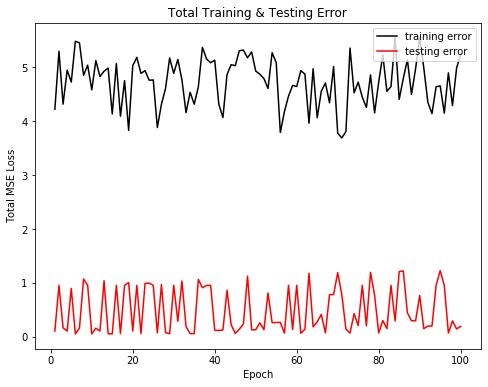

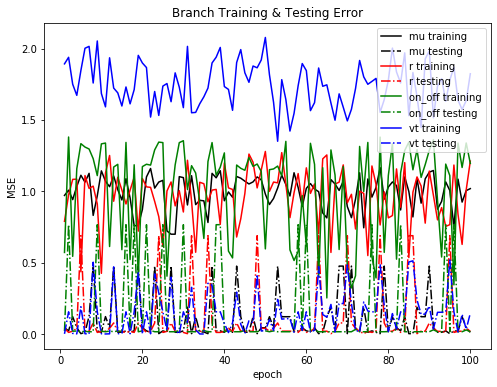

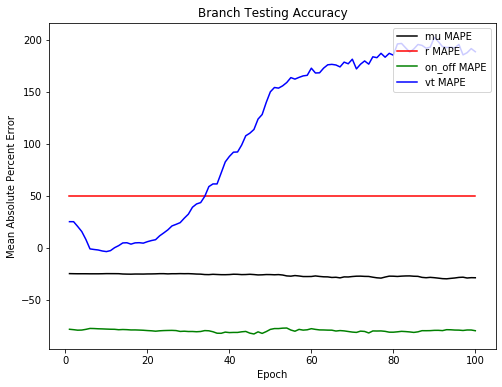

In [8]:
%autoreload
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OFET_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                       mu_train_epoch_losses, mu_test_epoch_losses,
                       r_train_epoch_losses, r_test_epoch_losses,
                       on_off_train_epoch_losses, on_off_test_epoch_losses,
                       vt_train_epoch_losses, vt_test_epoch_losses)

nuts.plot_OFET_df_accuracies(epochs, mu_test_epoch_accuracies, r_test_epoch_accuracies, 
                             on_off_test_epoch_accuracies, vt_test_epoch_accuracies)

In [9]:
model.eval()

with torch.no_grad():
    for inputs, mu_labels, r_labels, on_off_labels, vt_labels in testing_data_set:
        inputs = inputs.to(device)
        mu_labels = mu_labels.to(device)
        r_labels = r_labels.to(device)
        on_off_labels = on_off_labels.to(device)
        vt_labels = vt_labels.to(device)

        mu_out, r_out, on_off_out, vt_out = model(inputs)


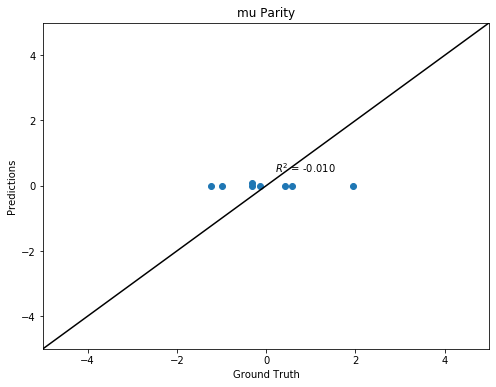

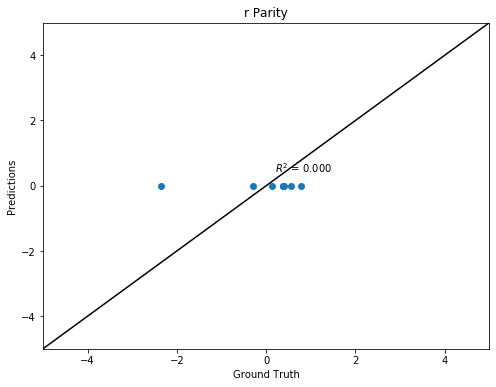

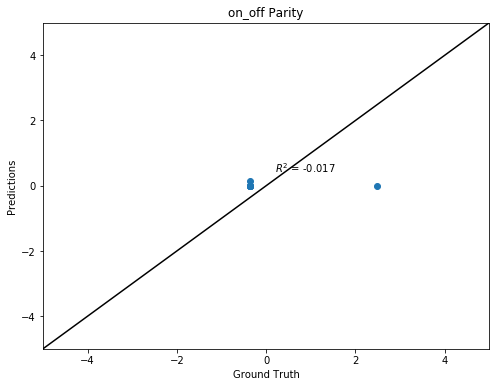

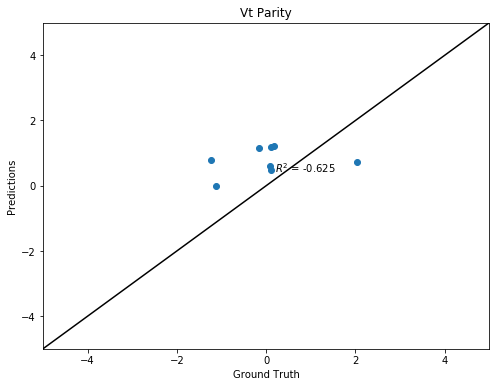

In [10]:
nuts.plot_OFET_parity(mu_labels, mu_out, r_labels, r_out,
                      on_off_labels, on_off_out, vt_labels, vt_out)